In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-3b1def15-1f21-5622-ac8e-57509b6b0cf0
device="cuda:0"
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
from timm.optim import Mars
from fastprogress import progress_bar
from torchvision.transforms.v2 import ToPILImage, PILToTensor, CenterCrop
from tft.mdct import mdct2d, inverse_mdct2d
from tft.utils import compand, decompand

class PerChannelNoiseScale(nn.Module):
    def __init__(self, num_channels, total_scale=4.0):
        super().__init__()
        self.num_channels = num_channels
        self.alpha = nn.Parameter(torch.zeros(num_channels))
        self.min_scale = 1.0
        self.total_scale = total_scale

    def forward(self):
        exp_alpha = torch.exp(self.alpha)
        alpha_sum = exp_alpha.sum()
        total_excess = (self.total_scale - self.min_scale) * self.num_channels
        S_prime = total_excess * (exp_alpha / alpha_sum)
        return self.min_scale + S_prime

class NoiseInjectionModel(nn.Module):
    def __init__(self, num_channels, total_scale=4.0):
        super().__init__()
        self.num_channels = num_channels
        self.noise_scales = PerChannelNoiseScale(num_channels, total_scale)
        self.hardtanh = nn.Hardtanh(min_val=-127.49, max_val=127.49)

    def forward(self, x):
        if self.training:
            S = self.noise_scales()
            S_half = (S / 2.0).view(1, -1, 1, 1)
            noise = (torch.rand_like(x) * 2.0 - 1.0) * S_half
            x = x + noise
            x = self.hardtanh(x)
            return x
        else:
            S = self.noise_scales() 
            S_view = S.view(1, -1, 1, 1)
            x = self.hardtanh(x)
            x = x / S_view
            x = torch.round(x)
            return x

    def scale(self, x_int):
        S = self.noise_scales()
        S_view = S.view(1, -1, 1, 1)
        x_float = x_int * S_view
        x_float = self.hardtanh(x_float)
        return x_float

class BottleneckNoiseModel(nn.Module):
    def __init__(self, in_channels=192, latent_channels=48, total_scale=4.0):
        super().__init__()
        self.conv_down = nn.Conv2d(in_channels, latent_channels, kernel_size=1, padding=0)
        self.noise_injection = NoiseInjectionModel(latent_channels, total_scale=total_scale)
        self.conv_up = nn.Conv2d(latent_channels, in_channels, kernel_size=1, padding=0)
        self.hardtanh = nn.Hardtanh(min_val=-127.49, max_val=127.49)

    def forward(self, x):
        x = self.conv_down(x)
        x = self.noise_injection(x)
        x = self.conv_up(x)
        x = self.hardtanh(x)
        return x

    def scale(self, x_int):
        x_float = self.noise_injection.scale(x_int)
        x_float = self.conv_up(x_float)
        x_float = self.hardtanh(x_float)
        return x_float


def entropy_code(ints):
    webp_bytes = []
    for sample in ints:
        webp_bytes.append([])
        for channel in sample:
            img = ToPILImage()((channel+127).to(torch.uint8))
            buff = io.BytesIO()
            img.save(buff, format='WEBP', lossless=True)
            webp_bytes[-1].append(buff.getbuffer())
    return webp_bytes
    
def entropy_decode(webp_bytes):
    batch_out = []
    for sample_buffers in webp_bytes:
        channel_tensors = []
        for buff in sample_buffers:
            with io.BytesIO(buff) as memfile:
                img = PIL.Image.open(memfile).convert('L') 
            t = PILToTensor()(img)
            t = t.to(torch.int16) - 127
            t = t.squeeze(0)
            channel_tensors.append(t)
        
        sample_tensor = torch.stack(channel_tensors, dim=0)
        batch_out.append(sample_tensor.unsqueeze(0))
    decoded = torch.cat(batch_out, dim=0)
    return decoded

env: CUDA_VISIBLE_DEVICES=MIG-3b1def15-1f21-5622-ac8e-57509b6b0cf0


In [2]:
F = 24; excess_noise = 3; latent_channels = 192

img = PIL.Image.open("kodim05.png").crop((0,0,512,512))
y = PILToTensor()(img).to(torch.float) / 127.5 - 1.0
y = y.to(device)
y_padded = CenterCrop((y.shape[1]+F, y.shape[2]+F))(y)
Y = compand(mdct2d(y_padded, 2*F, 2*F))/40
inputs = einops.rearrange(256*Y, 'c h w u v -> (c u v) h w').unsqueeze(0)
_, num_channels, height, width = inputs.shape

model = BottleneckNoiseModel(
    in_channels=3*F*F,
    latent_channels=latent_channels,
    total_scale=1+excess_noise
).to(device)

optimizer = Mars(model.parameters(), lr=1e-3, caution=True)
losses = []
val_loss = []
model.train()

pb = progress_bar(range(10000))
for i_step in pb:
    
    y_padded = CenterCrop((y.shape[1]+F, y.shape[2]+F))(y)
    Y = compand(mdct2d(y_padded, 2*F, 2*F))/40

    inputs = einops.rearrange(256*Y, 'c h w u v -> (c u v) h w').unsqueeze(0)
    outputs = einops.rearrange(
        model(inputs).squeeze(0),
        '(c u v) h w -> c h w u v',
        u=Y.shape[3],
        v=Y.shape[4]
    )/256
    
    y_hat = inverse_mdct2d(decompand(40*outputs))
    y_hat = CenterCrop((y.shape[1], y.shape[2]))(y_hat)
 
    loss = torch.nn.functional.mse_loss(y,y_hat)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    pb.comment = f"Loss: {loss.item():.4f}"

84.022 KB
9.359834329104283x compression ratio
9.287981859410431x dimension reduction


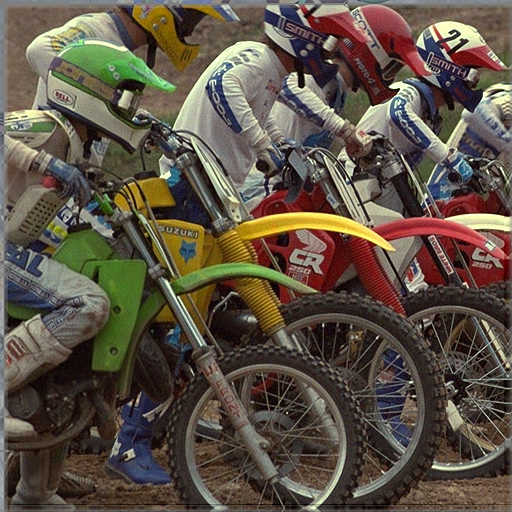

In [4]:
model.eval()
y_padded = CenterCrop((y.shape[1]+F, y.shape[2]+F))(y)
Y = compand(mdct2d(y_padded, 2*F, 2*F))/40

inputs = einops.rearrange(256*Y, 'c h w u v -> (c u v) h w').unsqueeze(0)
with torch.no_grad():
    latent = model.noise_injection(model.conv_down(inputs))
webp_bytes = entropy_code(latent)
size_bytes = sum( sum(len(b) for b in group) for group in webp_bytes)
print(f"{size_bytes/1e3} KB")
print(f"{y.numel()/size_bytes}x compression ratio")
print(f"{y.numel()/latent.numel()}x dimension reduction")
latent_decoded = entropy_decode(webp_bytes).to(device)
outputs = model.conv_up(model.noise_injection.scale(latent_decoded))

outputs = einops.rearrange(
    outputs.squeeze(0),
    '(c u v) h w -> c h w u v',
    u=Y.shape[3],
    v=Y.shape[4]
)/256

y_hat = inverse_mdct2d(decompand(40*outputs))
y_hat = CenterCrop((y.shape[1], y.shape[2]))(y_hat)
ToPILImage()((y_hat/2).clamp(-0.5,0.5)+0.5)

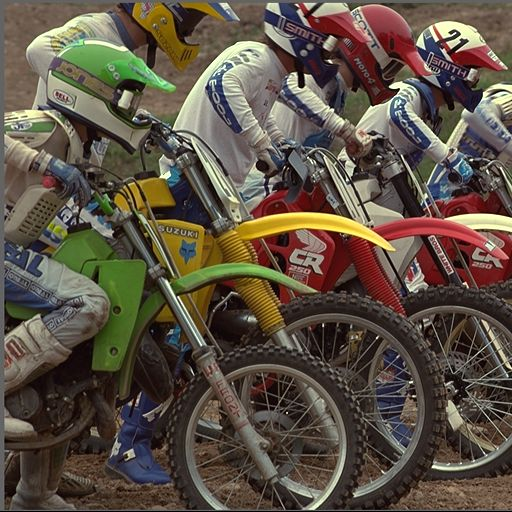

80K	test.jpg


In [7]:
img.crop((0,0,512,512)).save("test.jpg",quality=80)
display(PIL.Image.open("test.jpg"))
!du -sh test.jpg